In [8]:
!pip install pytransit
!pip install pyrr
!pip install emcee
!pip install corner

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pytransit import QuadraticModel
from decimal import Decimal
import emcee
import corner
from IPython.display import display, Math
import csv 
from numpy import savetxt
from numpy import loadtxt
from multiprocessing import Pool

s_per_day=24*3600.
M_sun=1.989e33 #g
R_sun=6.955e10 #cm
G=6.673e-8          ##units: cm**3 / g / s**2
cm_per_AU = 1.5E13          ##units: cm
g_per_MEarth=5.972e+27      ##units: g
cm_per_REarth=6.37e8 #cm 
cm_per_RSun=6.955e10

/apps/jupyter/6.5.2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Reading in the lightcurve from the CSV file
data = loadtxt('stellar_mass_0.66_stellar_radius_0.72.csv', delimiter=',')
time=data[:,0]
flux=data[:,1]
flux_err=data[:,2]


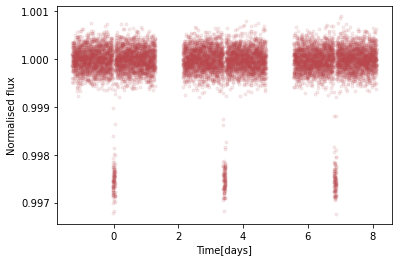

In [3]:
def f_lightcurve(time,period,rp,a,inc,ecc,omega):
    """
    Function for computing transit models for the set of 8 free paramters
    x - time array
    """
    tm = QuadraticModel()
    tm.set_data(time)
    om=omega/180*np.pi
    i=inc/180.0*np.pi
    lightcurve=tm.evaluate(k=rp, ldc=[0.0, 0.0], t0=0.0, p=period, a=a, i=i,e=ecc,w=om)
    return lightcurve

#Plotting the lightcurve first, just to see what it looks like!
plt.plot(time,flux,".", color='xkcd:dusty red', label='Data', alpha=0.1)
plt.xlabel("Time[days]")
plt.ylabel("Normalised flux")
plt.show()

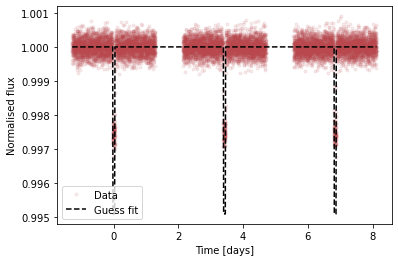

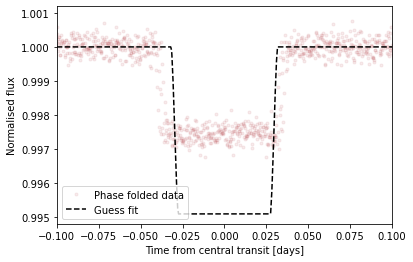

In [6]:
#HERE IS WHERE YOU ENTER YOUR GUESSES, FOR NUMBER 1
guess_period=3.42
guess_ronr=0.07
guess_aonr=20
guess_inc=90.0
guess_ecc=0.1
guess_omega=240

#Don't need to alter below here in this cell-------
guess=[guess_period, guess_ronr, guess_aonr, guess_inc,guess_ecc,guess_omega]

## Phasefold data time-array
phase = (time) % guess[0] / guess[0]
phase[np.where(phase>0.5)] -= 1 
sorted = np.argsort(phase)

plt.plot(time,flux,".", color='xkcd:dusty red', label='Data', alpha=0.1)
guess_lightcurve=f_lightcurve(time,*guess)
plt.plot(time,guess_lightcurve,'--k', label='Guess fit')
plt.legend(loc="lower left")
plt.ylabel("Normalised flux")
plt.xlabel("Time [days]")
plt.show()

## Plot data & model together, phase fold
plt.plot(phase*guess[0], flux, ".", color='xkcd:dusty red', label='Phase folded data', alpha=0.1)
plt.plot(phase[sorted]*guess[0], guess_lightcurve[sorted], '--k', label='Guess fit')
plt.legend(loc="lower left")
plt.xlim(-0.1, 0.1)
plt.xlabel("Time from central transit [days]")
plt.ylabel("Normalised flux")

plt.show()

In [8]:
#No need to alter anything in this cell
#This function bins the data, in order to save processing time during the MCMC fit
def rebin(nbin,time,flux):
    start_interval=time[1]-time[0]
    bin_interval=(start_interval)*nbin
    flux_bin=[]
    time_bin=[]
    err_bin=[]
    tmax=np.min(time)
    i=0
    while tmax<np.max(time):
        bincenter=np.min(time)+(i+0.5)*bin_interval
        index=np.where(np.abs(time-bincenter) < bin_interval/2.0)
        if len(time[index]):
            flux_bin=np.append(flux_bin,np.mean(flux[index]))
            time_bin=np.append(time_bin,np.mean(time[index]))
            err_bin=np.append(err_bin,np.std(flux[index])) 
            tmax=np.max(time[index])        
        i=i+1

    return time_bin,flux_bin,err_bin
        
#This bins to roughly one point every 5 minutes, though you can try different bins if you like!
time_bin,flux_bin,err_bin=rebin(5,time,flux)

In [9]:
#No need to alter anything in this cell
#How much can the MCMC stray from the original guesses? 
priors = [guess_period*0.9, guess_period*1.1,
          guess_ronr*0.5,guess_ronr*1.5,
         guess_aonr*0.3,guess_aonr*3.0,
         0, 90,
         0,0.99 ,
         0, 360]

#This function calculates the ``goodness of fit" of the model, using chi-squared
def log_likelihood(theta, time, flux, flux_err):
#     t0, per, rp, a, inc, ecc, w, baseline = theta
    model = f_lightcurve(time, *theta)
    sigma2 = flux_err ** 2 
    return -0.5 * np.sum((flux - model) ** 2 / sigma2 + np.log(2. * np.pi*sigma2))

#This function tells the code to spit the guess back if it wanders outside the acceptable range 
def log_prior(theta):
    # The parameters are stored as a vector of values, so unpack them
    per, rp, a, inc, ecc, w = theta
    # We're using only uniform priors:
    if priors[0] > per or per > priors[1]:
        return -np.inf
    if priors[2] > rp or rp > priors[3]:
        return -np.inf
    if priors[4] > a or a > priors[5]:
        return -np.inf
    if priors[6] > inc or inc > priors[7]:
        return -np.inf
    if priors[8] > ecc or ecc > priors[9]:
        return -np.inf
    if priors[10] > w or w > priors[11]:
        return -np.inf  
    return 0.0

## The full log-probability function is:
def log_probability(theta, time, flux, flux_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    #print(log_likelihood(theta, time, flux, flux_err))
    return lp + log_likelihood(theta, time, flux, flux_err)

In [11]:
#No need to alter anything in this cell
#This one may take a while to run!
#We have six dimensions, for each of the parameters we're fitting!
ndim = 6
nwalkers = ndim*8  # Number of walkers. It is recommended to be at least higher than twice 
                   # the amount of parameters being fit

# theta = [period, rp/Rstar, a/Rstar, inc, ecc, omega]
#How close to the original guess should I start exploring, for each parameter?
order_of_mag = np.array([1e-3, 1e-3, 0.5, 1e-3, 0.1,10])

pos = guess+ order_of_mag * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time_bin, flux_bin, err_bin))
sampler.run_mcmc(pos, 10000, progress=True)

#If your computer has multiprocessing capabilities, you can comment out the lines below instead of 
#using the two lines of code immediately above this. It will go faster!
#with Pool() as pool:
#    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time_bin, flux_bin, err_bin),pool=pool)
#    sampler.run_mcmc(pos, 10000, progress=True)

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/sarahba/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [08:35<00:00, 19.38it/s]


(91200,)


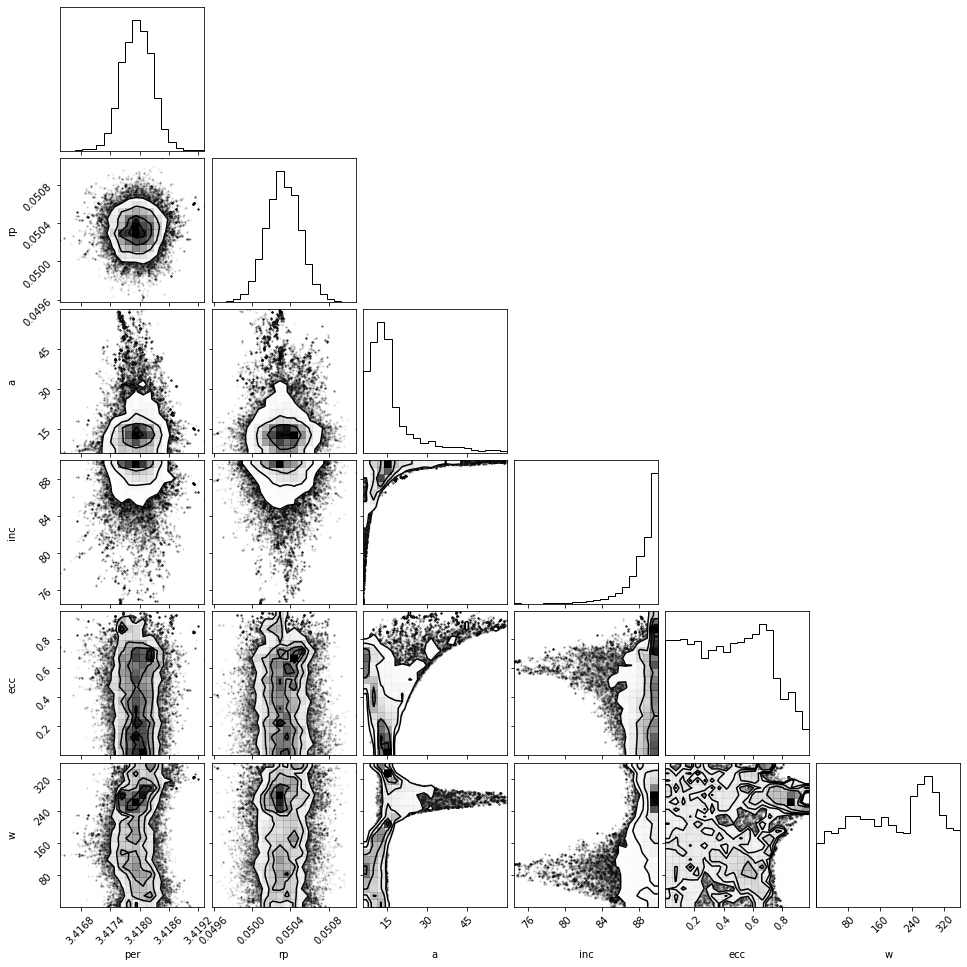

In [29]:
#No need to alter anything in this cell
flat_samples = sampler.get_chain(discard=500, thin=5, flat=True)

#This line saves your MCMC samples, since the cell above may have taken a long time to run!
savetxt('MCMC_samples.csv', flat_samples, delimiter=',')

labels = ["per", "rp", "a", "inc","ecc", "w" ]

fig = corner.corner(flat_samples, labels=labels)


Text(0, 0.5, 'Likelihood')

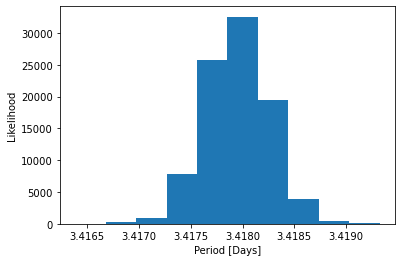

In [34]:
period_samples=flat_samples[:,0]
ronr_samples=flat_samples[:,1]
aonr_samples=flat_samples[:,2]
inc_samples=flat_samples[:,3]
ecc_samples=flat_samples[:,4]
omega_samples=flat_samples[:,5]

#Use your array of values for each parameter to determine the likeliest one! See below for a 
#histogram of the guesses for period
plt.hist(period_samples)
plt.xlabel('Period [Days]')
plt.ylabel('Likelihood')

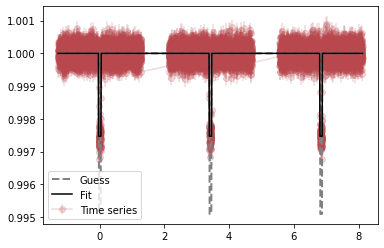

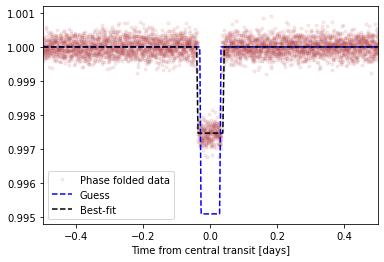

In [35]:
#Extract the likeliest values for your 6 parameters and enter them into this array!
fit=[3.4179,0.0503,13.7188,88.85,0.44,195.44]

#Generating a lightcurve from your guess
flux_guess = f_lightcurve(time, *guess)
plt.plot(time, flux_guess, '--', color='gray', label='Guess', lw=2, zorder=3)

#Generating a lightcurve from your best fit
flux_fit = f_lightcurve(time, *fit )
plt.plot(time, flux_fit, 'k', label='Fit', lw=1.5, zorder=10)

plt.errorbar(time, flux, flux_err,marker="o", color='xkcd:dusty red', label='Time series', alpha=0.2)
plt.legend()
plt.show()

## Phasefold data time-array
phase_fit = (time) % fit[0] / fit[0]
phase_fit[np.where(phase_fit>0.5)] -= 1 
sorted_fit = np.argsort(phase_fit)

## Plot data & model together, phase fold
plt.plot(phase*fit[0], flux, ".", color='xkcd:dusty red', label='Phase folded data', alpha=0.1)
plt.plot(phase[sorted]*guess[0], flux_guess[sorted], '--b', label='Guess')
plt.plot(phase_fit[sorted_fit]*fit[0], flux_fit[sorted_fit], '--k', label='Best-fit')
plt.legend()
plt.xlim(-0.5, 0.5)
plt.xlabel("Time from central transit [days]")
plt.show()